<a href="https://colab.research.google.com/github/dtabuena/Workshop/blob/main/DFOF_local.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tifffile
import numpy as np
# from google import colab
from matplotlib import pyplot as plt
import scipy
from tqdm import tqdm
import matplotlib as mpl
from scipy.signal import butter,filtfilt
import os


In [ ]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


In [ ]:
def df_trace(trace,ref_inds):
    f0 = np.mean(trace[ref_inds])
    return (trace-f0)/f0

def exp_func(xdata,a,b,c):
    return a*np.exp(xdata/-b) + c

def z_trace(trace):
    std = np.nanstd(trace)
    mean = np.nanmean(trace)
    z_param =  {'std':std, 'mean':mean}
    return (trace-mean)/std, z_param

def bleach_cor(trace,ref_inds,lpf=0.2,order=1):
    b, a = butter(order, lpf, btype='lowpass')
    trace_f = filtfilt(b, a, trace)
    y_fittable = trace_f[ref_inds]
    p0= [np.max(trace), 20000, np.min(trace)]
    min_bound = [0,1000,0]
    max_bound = [np.max(trace)*2,np.inf,np.max(trace)*2]
    p = scipy.optimize.curve_fit(exp_func, ref_inds, y_fittable,p0=p0,bounds=(min_bound,max_bound))
    bleach_trace = exp_func(np.arange(len(trace)), p[0][0], p[0][1], p[0][2])
    trace_corr = trace + (bleach_trace[0] - bleach_trace)    
    return trace_corr, bleach_trace, p[0]

def bleach_cor_PARAM(trace,param):
    bleach_trace = exp_func(np.arange(len(trace)), param[0], param[1], param[2])    
    trace_corr = trace + (bleach_trace[0] - bleach_trace)    
    return trace_corr, bleach_trace, p[0]

def bin_stack(im,bin_factor):
    height = im.shape[1] // bin_factor
    width = im.shape[2] // bin_factor
    im = im[:, :height * bin_factor, : width * bin_factor]
    im = im.reshape(im.shape[0], height, bin_factor, width, bin_factor)
    im = im.sum((2, 4), dtype='uint32')
    return im

def proccess_pxl(trace,ref_inds,df_ind,return_df=True,return_z=True,nan_thresh = 3):
    trace = trace.astype('float32')    
    trace_corr, _, bleach_param = bleach_cor(trace,ref_inds)
    if return_df: trace_corr = df_trace(trace_corr,df_inds)
    if return_z:
        trace_test,_ = z_trace(trace_corr)
        trace_corr[abs(trace_test)>=nan_thresh] = np.nan
        trace_corr[abs(trace_test)<nan_thresh],v = z_trace( trace_corr[abs(trace_test)<nan_thresh] )
#         trace_corr,_ = z_trace(trace_corr)
    return trace_corr, bleach_param

def vec_image(im):
    og_shape = im.shape
    im_vec = np.reshape(im,[og_shape[0],og_shape[1]*og_shape[2]])
    return im_vec, og_shape

def unvec_image(im,og_shape):
    im = np.reshape(im,[og_shape[0],og_shape[1],og_shape[2]])
    return im

In [ ]:
local_link = os.path.normpath('C:\\Users\\dennis.tabuena\\Dropbox (Gladstone)\\2023\\May 22\\S1_10Hz_CNT[1-6072_EX0].TIF')
im = tifffile.imread(local_link, maxworkers=6)
im = bin_stack(im,4)
im = scipy.ndimage.gaussian_filter(im, .4, radius = [10,2,2])
im_vec, og_shape = vec_image(im)
tifffile.imwrite('C://Users//dennis.tabuena//Documents//Downloads//Ref_im.TIF', np.median(im,axis=0) )

In [ ]:
im_vec =im_vec.astype('float32')
ref_inds= np.concatenate([np.arange(100,1000),np.arange(4980,4999)])
df_inds = np.arange(900,1000)
param_list = np.zeros([3,im_vec.shape[1]])
for pix in tqdm( np.arange(im_vec.shape[1]) ):
    im_vec[:,pix],bleach_param = proccess_pxl(im_vec[:,pix],ref_inds,df_inds)
    param_list[:,pix] = bleach_param
im_unvec = unvec_image(im_vec,og_shape)
tifffile.imwrite('C://Users//dennis.tabuena//Documents//Downloads//BC_file.TIF', im_unvec)

100%|███████████████████████████████████████████████████████████████████████████| 22500/22500 [03:15<00:00, 115.29it/s]


In [ ]:
im_unvec = unvec_image(im_vec,og_shape)
im_unvec = scipy.ndimage.gaussian_filter(im_unvec, .5, radius = [3,3,3])
im_vec, og_shape = vec_image(im_unvec)

In [ ]:
og_shape

(6072, 150, 150)

In [ ]:
foi = np.arange(1250,3500)


up_spread_thresh = 1
down_spread_thresh = -1

high_bool = im_vec[foi,:].T>up_spread_thresh
low_bool = im_vec[foi,:].T<down_spread_thresh


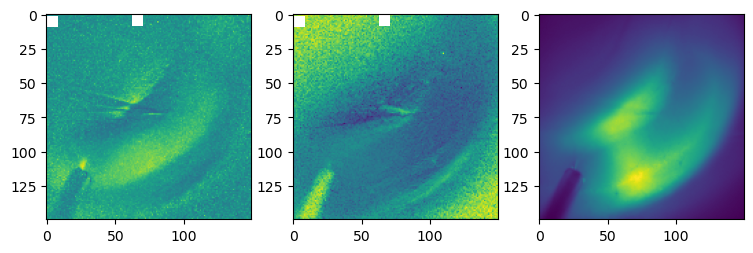

In [ ]:
fig,ax =plt.subplots(1,3,figsize=(9,3))
up_max = unvec_image(np.max(im_vec[foi,:],axis=0),[1, og_shape[1],og_shape[2]])
up_max[0,0,0] = 0
cb_1 = ax[0].imshow( up_max[0,:,:]) #  ,levels=np.arange(-5,5,.5)
# fig.colorbar(cb_1, ax=ax[0])
down_max = unvec_image(np.min(im_vec[foi,:],axis=0),[1, og_shape[1],og_shape[2]])
cb_2 = ax[1].imshow( down_max[0,:,:] ) # ,levels=np.arange(-5,5,.5)
# fig.colorbar(cb_2, ax=ax[1])
# plt.tight_layout()
ax[2].imshow(im[0,:,:])

C:\Users\dennis.tabuena\AppData\Local\Temp\ipykernel_10808\3249004238.py:15: RuntimeWarning: All-NaN slice encountered
  up_image = np.nanmin(ind,axis=0)


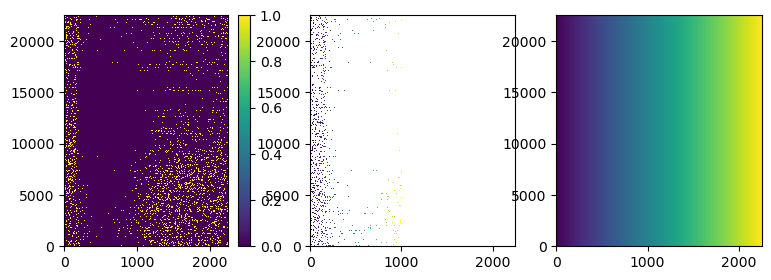

In [ ]:
# p=1300

up_spread_thresh = 1
down_spread_thresh = -1

high_bool = im_vec[foi,:]>up_spread_thresh
low_bool = im_vec[foi,:]<down_spread_thresh


trigs_up = np.diff(high_bool,axis=1,prepend=0)
x_g,y_g =np.meshgrid(np.arange(high_bool.shape[1]),np.arange(high_bool.shape[0]))
ind = np.multiply(trigs_up>0 , y_g).astype('float')
ind[ind==0]=np.nan
ind[ind>1000]=np.nan
up_image = np.nanmin(ind,axis=0)
# print(up_image[p])
fig,ax =plt.subplots(1,3,figsize=(9,3))
cb = ax[0].pcolorfast((trigs_up>0).T)
ax[1].pcolorfast( ind.T)
ax[2].pcolorfast( y_g.T )
fig.colorbar(cb, ax=ax[0])




In [ ]:
# up_image = np.nanmin(ind.astype('float'),axis=0)
# # plt.plot(up_image)
# plt.show()
# print(up_image)
# up_image = unvec_image(up_image,[1, og_shape[1],og_shape[2]])
# plt.imshow(scipy.ndimage.median_filter(up_image[0,:,:],size=5)

In [ ]:
# im_unvec = unvec_image(im_vec,og_shape)
# tifffile.imwrite('C://Users//dennis.tabuena//Documents//Downloads//BC_file.TIF', im_unvec)